# SentencePiece project
GD 노드 2 

프로세스는 다음과 같다.
1. 데이터 불러오기 및 전처리
2. 데이터 분석
3. SentnecPiece 학습
4. 모델 성능 분석

## 1. 데이터 불러오기 및 전처리
네이버 영화리뷰 데이터 불러오기 후 중복과 결측치를 제거한다.   
 

In [1]:
import os

import tensorflow as tf
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
%matplotlib inline
import re
from konlpy.tag import Okt 
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

Duplicate key in file PosixPath('/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 250 ('font.family:  NanumGothic')


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 중복, 결측치 제거

In [2]:
test_data = test_data.dropna(axis=0)

In [3]:
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any') 
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any') 
print(len(train_data), len(test_data))

146182 49157


In [4]:
# sampling
raw = list(train_data['document']) + list(test_data['document'])
print("Data Size:", len(raw))
list(map(str, raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 195339
Example:
>> 아 더빙.. 진짜 짜증나네요 목소리
>> 나름 심오한 뜻도 있는 듯. 그냥 학생이 선생과 놀아나는 영화는 절대 아님
>> 단순하면서 은은한 매력의 영화
>> 보는내내 그대로 들어맞는 예측 카리스마 없는 악역
>> 뭐냐..시작하고 3분만에 나왔다. 리플릿 사진 보며 불안하더니만..


## 2. 데이터 분석
문장의 길이에 따른 분포를 분석하고 각 데이터가 어떻게 생겼는지 살핀다.   
그리고 적절한 최대길이로 분할한다.

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


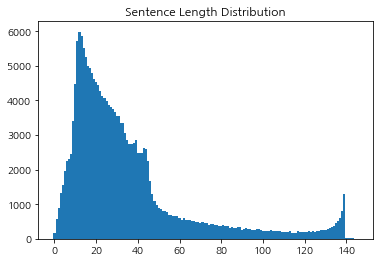

In [5]:
# data distribution
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    if type(sen) == type(1.0):
        print(sen)
    sen = str(sen)
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:
    #sen = str(sen)
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### 데이터 확인

In [6]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 20: return

check_sentence_with_length(raw, 1)

아
잼
1
4
굿
짱
휴
.
음
?
ㅎ
ㅋ
즐
♥
굳
네
ㅇ
k
ㅠ
쒯
♬


In [7]:
for idx, _sum in enumerate(sentence_length):
    # # 문장 내 단어의 개수가 1500을 초과하는 인덱스를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 5
Outlier Index: 6
Outlier Index: 7
Outlier Index: 8
Outlier Index: 9
Outlier Index: 10
Outlier Index: 11
Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17
Outlier Index: 18
Outlier Index: 19
Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24
Outlier Index: 25
Outlier Index: 26
Outlier Index: 27
Outlier Index: 28
Outlier Index: 29
Outlier Index: 30
Outlier Index: 31
Outlier Index: 32
Outlier Index: 33
Outlier Index: 34
Outlier Index: 35
Outlier Index: 36
Outlier Index: 37
Outlier Index: 38
Outlier Index: 39
Outlier Index: 40
Outlier Index: 41
Outlier Index: 42
Outlier Index: 43
Outlier Index: 44
Outlier Index: 45
Outlier Index: 46
Outlier Index: 47


In [8]:
check_sentence_with_length(raw, 140)

데너리스 타르 가르엔...나도 용의주인이 되고 싶다...누이랑,근친상간이나 하고 다닐지라도,소설 속에선 제일 멋진 놈이 자이메 라니스터였는데,드라마속에선,드래곤(용)이 제일 멋지네(웃음)감독님 토르-2 다크 월드는 말아 잡수셨을지라도,기본 선방은 했음
아~ 진짜 조금만 더 손 좀 보면 왠만한 상업 영화 못지 않게 퀄리티 쩔게 만들어 질 수 있었는데 아쉽네요 그래도 충분히 재미있었습니다 개인적으로 조금만 더 잔인하게 더 자극적으로 노출씬도 화끈하게 했더라면 어땠을까 하는 국산영화라 많이 아낀 듯 보임
평점조절위원회에서 나왔습니다(웃음)김혜선은 @내일이 오면@의 김순정,순정이 역할이 제일이다.팜므파탈로써,그 정도까지 잘해낼 줄은,정말 의외였어...연기20년 한사람에게 요즘 사극에서 벌어지고 있는,그녀에 대한 연기논란은 왠지 코미디의한장면 같음(웃음)
사실여부를 떠나,알고왔던 아더와 너무 매칭이 안돼더라.원탁기사중 실제 검술 최고수는 랜슬롯으로 알고 있는데,트리스탄보다 못하고,싸우는 검술은 마치 중국검술 흉내낸거 같은게;; 그리고 란슬롯이 실제는 쌍검였나?너무 매칭이 안대 하튼 ㅋ기네비어역도 미스.
진짜 이건 아님ㅋㅋㅋㅋㅋ액션영화좋아해서 액션영화만 다운받아서 꾸준히 본게 벌써 몇년인 사람임 근데 이건 진짴ㅋㅋㅋㅋㅋㅋ아무리 점수 잘 줘도 100점 만점에 10점?ㅡㅡ돈주고봤는데너무아깝다진짜ㅜㅜ그리고대체 왜 13구역 타이틀을 달고나왔는지 모르겠음 실망
영화'산업'이라고 하잖는가? 이딴식으로 홍보 해놓고 속여서 팔았다는 게 소비자 입장에서는 짜증난다. 그나마 다행은 아주 싸구려를 상급품으로 속여판 게 아니라는 점. 그래서 1점. 차라리 연상호 감독 작품 처럼 홍보가 됐다면, 그 비슷하게 만이라도 하지
화려한 색채때문에 눈이 아프지만 그 나름대로 화려연예계여자욕망에대해 표현해냈던거같다 보는내내 진짜 리리코심정가진 연옌들도 있을거같고..나를한번도보지못하고알지못하는사람들이날어떻게사랑하냐그런대사 나왔을때 소름돋더라 연예인들은 많은사랑받으면서도 참 허전할듯
히가시노 게이고의 추리소

Data Size: 194543
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 36


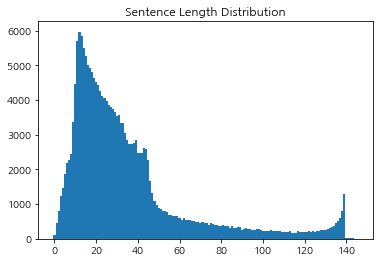

In [9]:
# 중복 제거
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    sen = str(sen)
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sen = str(sen)
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### 데이터 분할
너무 긴 문장에 대해서 학습에 방해된다고 판단하여 제거한다. (SentencPiece) 

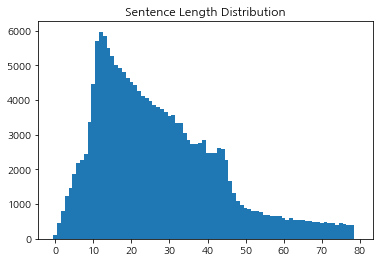

In [10]:
max_len = 80
min_len = 0

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sen = str(sen)
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

## 3. SentencePiece 학습
SentencePiece의 vocab_size를 10,000과 5,000으로    
model_type을 unigram과 bpe로 하여 4가지를 만든다.

In [11]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 10000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_10k --vocab_size={}'.format(temp_file, vocab_size)    
)
spm.SentencePieceTrainer.Train(
    '--input={} --model_type=bpe --model_prefix=korean_spm_bpe_10k --vocab_size={}'.format(temp_file, vocab_size)    
)
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_5k --vocab_size={}'.format(temp_file, vocab_size // 2)    
)
spm.SentencePieceTrainer.Train(
    '--input={} --model_type=bpe --model_prefix=korean_spm_bpe_5k --vocab_size={}'.format(temp_file, vocab_size // 2)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-rw-r-- 1 aiffel-dj28 aiffel-dj28 414127  4월  6 17:20 korean_spm_10k.model
-rw-rw-r-- 1 aiffel-dj28 aiffel-dj28 185330  4월  6 17:20 korean_spm_10k.vocab
-rw-rw-r-- 1 aiffel-dj28 aiffel-dj28 317147  4월  6 17:22 korean_spm_5k.model
-rw-rw-r-- 1 aiffel-dj28 aiffel-dj28  83900  4월  6 17:22 korean_spm_5k.vocab
-rw-rw-r-- 1 aiffel-dj28 aiffel-dj28 408235  4월  6 17:21 korean_spm_bpe_10k.model
-rw-rw-r-- 1 aiffel-dj28 aiffel-dj28 149445  4월  6 17:21 korean_spm_bpe_10k.vocab
-rw-rw-r-- 1 aiffel-dj28 aiffel-dj28 314970  4월  6 17:22 korean_spm_bpe_5k.model
-rw-rw-r-- 1 aiffel-dj28 aiffel-dj28  66181  4월  6 17:22 korean_spm_bpe_5k.vocab
-rw-rw-r-- 1 aiffel-dj28 aiffel-dj28 414123  4월  6 16:11 korean_spm.model
-rw-rw-r-- 1 aiffel-dj28 aiffel-dj28 185330  4월  6 16:11 korean_spm.vocab


In [12]:
#check
s = spm.SentencePieceProcessor()
s.Load('korean_spm_10k.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1843, 10, 436, 15, 1348, 10, 174, 16, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


## 4. 모델 성능 분석
SentencePiece의 성능을 분석하기 위해서 간단한 LSTM 모델을 사용한다.   
4가지의 SentencePiece와 Mecab을 비교 분석해본다.

### 데이터 전처리
모델에 학습하기 위해서 데이터를 모델에 넣을 수 있게 변환해준다.

In [13]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre',maxlen=80)

    return tensor, word_index, index_word

In [14]:
#sp_tokenize(s, corpus) 사용예제
my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0  490 3218   14 1234 2038    4]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
  1540 2051  215  649   10    3   17 9939 1016    7]]


In [15]:
s.Load('korean_spm.model')
train_test, word_index, index_word = sp_tokenize(s, raw)

In [16]:
train_test.shape

(195339, 80)

In [17]:
# 데이터 분할
X_train = train_test[:146182]
X_test = train_test[146182:]

y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 80)
(96182,)


### 모델 만들기
토크나이저의 성능을 비교하기 위해서 간단한 모델을 만든다.

In [18]:
vocab_size = 10000    # 어휘 사전의 크기입니다.
word_vector_dim = 200  # 워드 벡터의 차원수

# model 설계
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.LSTM(word_vector_dim))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model1.add(keras.layers.Dense(10, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 10)                2010      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 2,322,821
Trainable params: 2,322,821
Non-trainable params: 0
_________________________________________________________________


### 모델 훈련 및 성능 평가
각각의 토크나이저 모델에 대해서 학습을 시키고 성능을 평가한다.

In [19]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history1 = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
188/188 [==============================] - 17s 93ms/step - loss: 0.4361 - accuracy: 0.7929 - val_loss: 0.3432 - val_accuracy: 0.8507
Epoch 2/5
188/188 [==============================] - 16s 86ms/step - loss: 0.3130 - accuracy: 0.8668 - val_loss: 0.3320 - val_accuracy: 0.8541
Epoch 3/5
188/188 [==============================] - 16s 87ms/step - loss: 0.2744 - accuracy: 0.8824 - val_loss: 0.3388 - val_accuracy: 0.8540
Epoch 4/5
188/188 [==============================] - 17s 89ms/step - loss: 0.2384 - accuracy: 0.8979 - val_loss: 0.3594 - val_accuracy: 0.8507
Epoch 5/5
188/188 [==============================] - 17s 91ms/step - loss: 0.2029 - accuracy: 0.9118 - val_loss: 0.3956 - val_accuracy: 0.8466


In [20]:
results = model1.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 10s - loss: 0.4058 - accuracy: 0.8437
[0.4057556092739105, 0.8437455296516418]


In [21]:
def pipeline(spms, vocab):
    s = spm.SentencePieceProcessor()
    s.load(spms)
    train_test, word_index, index_word = sp_tokenize(s, raw)
    X_train = train_test[:146182]
    X_test = train_test[146182:]

    y_train = np.array(list(train_data['label']))
    y_test = np.array(list(test_data['label']))

    # validation set 50000건 분리
    x_val = X_train[:50000]   
    y_val = y_train[:50000]

    # validation set을 제외한 나머지 
    partial_X_train = X_train[50000:]  
    partial_y_train = y_train[50000:]
    
    vocab_size = vocab    # 어휘 사전의 크기입니다.
    word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

    # model 설계
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(keras.layers.LSTM(word_vector_dim))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
    model.add(keras.layers.Dense(10, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    model.summary()
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

    epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

    history = model.fit(partial_X_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1)
    results = model.evaluate(X_test,  y_test, verbose=2)
    print(results)
    return history

In [22]:
pipeline('korean_spm_5k.model',5000)
pipeline('korean_spm_bpe_5k.model',5000)
pipeline('korean_spm_bpe_10k.model',10000)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2010      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,322,821
Trainable params: 1,322,821
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
188/188 [==============================] - 15s 82ms/step - loss: 0.4484 - accuracy: 0.7875 - val_loss: 0.3537 - val_accuracy: 0.8451
Epoch 2/5
188/188 [==============================] - 15s 79ms/step - loss: 0.3383 - accuracy: 0.852

### Mecab 모델
Mecab에 대해서도 진행을 한다.

In [23]:
# using konlpy
from konlpy.tag import Mecab
tokenizer = Mecab()
#미리 정의한 불용어
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] 
num_words = 10000

# 함수 기능
# 데이터의 중복 제거   
# NaN 결측치 제거   
# 한국어 토크나이저로 토큰화   
# 불용어(Stopwords) 제거   
# 사전word_to_index 구성   
# 텍스트 스트링을 사전 인덱스 스트링으로 변환   
# X_train, y_train, X_test, y_test, word_to_index 리턴   
def load_data(train_data, test_data, num_words=num_words):
    # 중복, 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    # 사전 구성
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    # 변환 text to index
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [24]:
# index to text 사전
index_to_word = {index:word for word, index in word_to_index.items()}

In [25]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [26]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 한다  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [27]:
# 패딩 추가 (using keras.preprocessing.sequence.pad_sequences)
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [29]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(word_vector_dim))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,322,417
Trainable params: 2,322,417
Non-trainable params: 0
_________________________________________________________________


In [30]:
# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


In [31]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
188/188 [==============================] - 11s 60ms/step - loss: 0.4326 - accuracy: 0.8003 - val_loss: 0.3506 - val_accuracy: 0.8488
Epoch 2/5
188/188 [==============================] - 10s 53ms/step - loss: 0.3241 - accuracy: 0.8612 - val_loss: 0.3405 - val_accuracy: 0.8501
Epoch 3/5
188/188 [==============================] - 10s 53ms/step - loss: 0.2897 - accuracy: 0.8764 - val_loss: 0.3427 - val_accuracy: 0.8538
Epoch 4/5
188/188 [==============================] - 10s 54ms/step - loss: 0.2556 - accuracy: 0.8923 - val_loss: 0.3500 - val_accuracy: 0.8548
Epoch 5/5
188/188 [==============================] - 10s 53ms/step - loss: 0.2274 - accuracy: 0.9047 - val_loss: 0.3656 - val_accuracy: 0.8536


In [32]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 7s - loss: 0.3730 - accuracy: 0.8486
[0.373012900352478, 0.848587155342102]


### 정리
위에서 나온 것들을 정리하면 다음과 같다.
먼저 Mecab의 경우 test acc: 0.848, val acc: 0.853   
SentencePiece의 경우   
vocab size = 10,000, model = unigram: test acc: 0.843, val acc: 0.846   
vocab size = 5,000, model = unigram: test acc: 0.848, val acc: 0.852   
vocab size = 5,000, model = bpe: test acc: 0.844, val acc: 0.848   
vocab size = 10,000, model = bpe: test acc: 0.842, val acc: 0.846   
이다.
정리하면 bpe 보다 unigram이 더 좋은 성능을 보였고,   
큰 어휘(10,000)보다 작은 어휘(5,000)가 더 좋은 성능을 보였다.   
그리고 sentencePiece보다는 Mecab이 좀 더 좋은 성능을 보였다.   
그러나 유의미한 차이를 보인 것 같지는 않다.

## 회고 및 루브릭 평가

### 루브릭 평가 항목
1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?
	(코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?)
2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?
	(SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.)
3. SentencePiece의 성능을 다각도로 비교분석하였는가?
	(SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.)

### 평가 항목에 대한 수행
1. SentencePiece를 이용하여 모델을 만들기 과정을 정상적으로 진행을 했다. 
2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 80% 이상의 정확도를 얻었다.
3. SentencePiece의 여러 가지 옵션을 사용하여 비교 분석하였다.

### 회고

노션에 공지된 꼭 포함이 되어야 할 점
- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**

---
- **어려웠던 점**    
크게 없었던 것 같다.

---
- **알아낸 점**    
SentencePiece 사용법에 대해서 배울 수 있었다.

- **모호한 점**    
SentencePiece의 옵션 변경이나 다른 토크나이저를 사용해도 크게 성능이 차이가 나지 않는데 그 이유가 좀 모호하다.

---
- **시도한 것들**   
SetencePiece에 여러 가지 옵션을 바꾸어 실험을 하였다.

---
- **루브릭 평가 관련 지표**   
제 예상에는 모두 달성되었다고 생각한다. 그 이유는 위에 있는 **평가 항목에 대한 수행**에 나와있다.  
- **자기 다짐** 및 **나의 생각들**      
Going deeper 노드라서 좀 더 어려운 것들이 나올 줄 알았는데 생각보다 쉬웠다. 내가 느끼기에는 저번 E 노드와 큰 차이가 없었던 것 같다. 그래도 점점 갈수록 어려워진다고 해서 기대를 하고 있다. 어쨌든 이전에 nlp를 혼자 공부를 했던 것이 다시 나오니까 다시 복습하는 느낌이 들었다.
